In [1]:
import sys
import os
sys.path.append(os.path.join(os.environ['HOME'], 'Isca'))    # So can access functions in isca_tools which is in home/Isca directory
import isca_tools
from isca_tools.utils.moist_physics import lcl_temp, rh_from_sphum, saturation_vapor_pressure, mixing_ratio_from_sphum, dry_profile, moist_profile
from isca_tools.utils.radiation import frierson_net_toa_sw_dwn
from isca_tools.utils.constants import kappa, epsilon
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from scipy import optimize

In [2]:
# Load dataset
exp_name = 'convective_coupling/aquaplanet/d5_2'
ds = isca_tools.load_dataset(exp_name)
namelist = isca_tools.load_namelist(exp_name)  # Need this for albedo_value
albedo = namelist['mixed_layer_nml']['albedo_value']
tau = namelist['two_stream_gray_rad_nml']['atm_abs']
p_full = namelist['spectral_dynamics_nml']['reference_sea_level_press']     # pressure of entire atmosphere in Pa

## Spin up
The net flux converges, even if not exactly towards 0. I am still not sure if the $(1-\alpha \exp^{-\tau})$ prefactor is correct.
I use this prefactor because, on way from space to surface, shortwave radiation gets absorbed due to shortwave optical depth so
that the fraction of incoming that reaches the surface is $\exp^{-\tau}$.
A fraction $\alpha$ of this then gets reflected and returns to space.
[Isca](https://execlim.github.io/Isca/modules/two_stream_gray_rad.html#frierson-byrne-schemes) has no absorption of shortwave radiation of this upward reflected shortwave radiation.

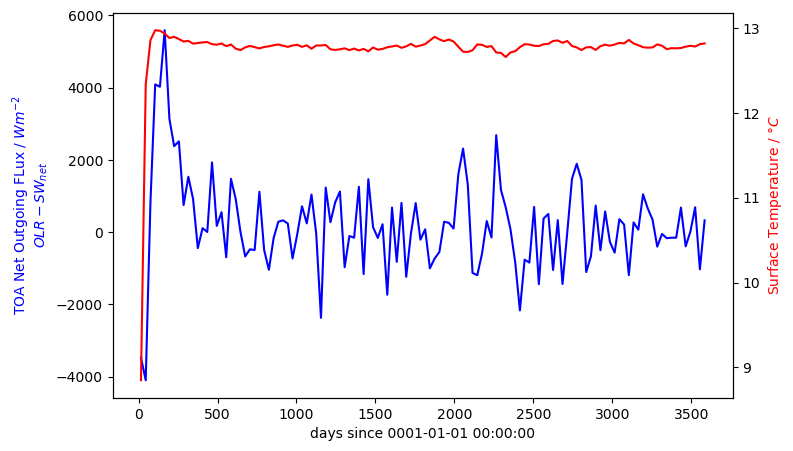

In [6]:
# Plot spin up time
fig, ax = plt.subplots(1,1, figsize=(8, 5))
# 101325 is the default reference pressure used by Isca if not set in the constants_nml module
# isca_tools.plot.plot_spin_up(ds.olr, ds.swdn_toa*(1-albedo*np.exp(-tau*(p_full/101325)**4)), ds.temp_2m, ax)
isca_tools.plot.plot_spin_up(ds.olr, frierson_net_toa_sw_dwn(ds.swdn_toa, ds.ps, albedo, tau), ds.temp_2m, ax)
# ax.set_ylim([-2000, 2000]);

## Lifting Condensation Level
Look at a particular latitude, longitude coordinate and see if follows dry adiabat up to LCL and then moist adiabat.

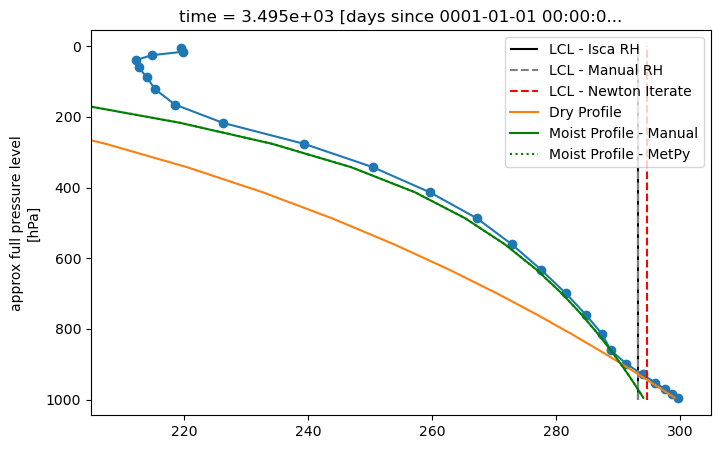

In [28]:
ds_tropics = ds.sel(lon=[240.125], lat=[10], time=[3500], method="nearest")
fig, ax = plt.subplots(1,1, figsize=(8, 5))
ax.scatter(ds_tropics.temp.to_numpy(), ds_tropics.temp.pfull.to_numpy())        # Add data points to see how discrete data is
ds_tropics.temp.plot(yincrease=False, y='pfull', ax=ax);
trop_lcl = lcl_temp(ds_tropics.temp_2m, ds_tropics.rh_2m).to_numpy()
ax.vlines(trop_lcl,1000,0,colors='k', label='LCL - Isca RH');

# Calculate relative humidity from specific humidity and check that it gives the same LCL, which it should in the tropics.
trop_rh_2m_manual = rh_from_sphum(ds_tropics.sphum_2m, ds_tropics.temp_2m, ds_tropics.ps)
trop_lcl2 = lcl_temp(ds_tropics.temp_2m, trop_rh_2m_manual).to_numpy()
ax.vlines(trop_lcl2,1000,0, linestyles='--',colors='grey', label='LCL - Manual RH');
plt.legend();


def lcl_opt_func(x):
    # Isca solves for LCL temperature by using Newton iteration to solve nonlinear equation
    # based on the fact that potential temperature at LCL is the same as it is at the parcel origin because
    # there is dry air in between, and also that mixing ratio is conserved between the surface and the LCL.
    p = float(ds_tropics.ps)
    p_ref = 1e5
    r = mixing_ratio_from_sphum(float(ds_tropics.sphum_2m))

    theta = x*(p_ref/p)**kappa     # potential temperature
    value = theta**(-1/kappa) * p_ref * r/(epsilon+r)
    # value = x**(-1/kappa) * p * r/(epsilon+r)

    # sat_p_holden = 611 * np.exp(2.5e6/461.41 * (1/273.15 - 1/x))
    # return value - sat_p_holden / x**(1/kappa)
    return value - saturation_vapor_pressure(x)/x**(1/kappa)
lcl_newton = optimize.newton(lcl_opt_func, 270)

ax.vlines(lcl_newton,1000,0, linestyles='--',colors='red', label='LCL - Newton Iterate');

dry_temp = dry_profile(ds_tropics.temp_2m, ds_tropics.ps, ds_tropics.temp.pfull*100)
dry_temp.plot(ax=ax, y='pfull', label='Dry Profile')

moist_temp = moist_profile(float(ds_tropics.temp_2m), float(ds_tropics.ps), ds_tropics.temp.pfull.to_numpy()*100)
p_moist_start = ds_tropics.temp.pfull.to_numpy().flatten()[-7] * 100
temp_moist_start = ds_tropics.temp.to_numpy().flatten()[-7]
moist_temp = moist_profile(temp_moist_start, p_moist_start, ds_tropics.temp.pfull.to_numpy()*100)
ax.plot(moist_temp, ds_tropics.temp.pfull, color='green', label='Moist Profile - Manual')

from metpy.units import units
from metpy.calc import moist_lapse
metpy_moist_temp = moist_lapse(ds_tropics.temp.pfull.to_numpy()*100 * units.pascal, temp_moist_start*units.kelvin, p_moist_start * units.pascal)
ax.plot(metpy_moist_temp, ds_tropics.temp.pfull, color='green', linestyle=':', label='Moist Profile - MetPy')

ax.set_xlim([205,305])
plt.legend();


From the above plot, it appears that the temperature profile continues along the dry adiabat for one data point more than you would expect based on the computed LCL level.

A potential issue may be that the [critical reference humidity](https://execlim.github.io/Isca/modules/convection_simple_betts_miller.html#namelist-options) option, `rhbm`, used to compute the profile is 0.7 not 1.

### Isca iteration computation of LCL temperature

The red line above is an attempt to replicate how the [LCL temperature is computed](https://github.com/ExeClim/Isca/blob/9560521e1ba5ce27a13786ffdcb16578d0bd00da/src/atmos_param/qe_moist_convection/qe_moist_convection.F90#L1092-L1130) in Isca with the [Simple Betts-Miller](https://jduffield65.github.io/Isca/namelists/convection/qe_moist_convection/) convection scheme.

It is based on two properties of dry ascent:

Potential temperature is conserved so surface potential temperature = potential temperature at the $LCL$:
$$\theta = \theta_{surface} = T_{surface}\bigg(\frac{p_{ref}}{p_{surface}}\bigg)^{\kappa} = \theta_{LCL}(T_{LCL}, p_{LCL}) = T_{LCL}\bigg(\frac{p_{ref}}{p_{LCL}}\bigg)^{\kappa}$$

Mixing ratio, $w$, is conserved in unsaturated adiabatic ascent because there is no precipitation, and at the $LCL$, $w_{LCL} = w_{sat}$ because by definition at the $LCL$, the air is saturated:

$$w = w_{surface} = \frac{q_{surface}}{1-q_{surface}} = w_{sat} = \frac{\epsilon e_s(T_{LCL})}{p_{LCL}-e_s(T_{LCL})}$$

$q$ is specific humidity, $\epsilon = R_{dry}/R_v$ is the ratio of gas constant for dry air to vapour and $\kappa = R_{dry}/c_p$. $p_{ref}$ is taken to be $100,000 Pa$ to be consistent with the [value used in Isca](https://github.com/ExeClim/Isca/blob/9560521e1ba5ce27a13786ffdcb16578d0bd00da/src/atmos_param/qe_moist_convection/qe_moist_convection.F90#L74-L75).

So we have two equations for two unknowns, $T_{LCL}$ and $p_{LCL}$. By eliminating $p_{LCL}$, we can get an equation where RHS is just a function of $T_{LCL}$ and the LHS consists only of known quantities:

$$\theta(T_{surface})^{\kappa}p_{ref} \frac{w(q_{surface})}{w(q_{surface}) + \epsilon} = T_{LCL}^{-1/\kappa}e_s(T_{LCL})$$

This can then be solved using Newton iteration to get the value of $T_{LCL}$.
